---
> 「生まれ生まれ生まれ生まれて生の始めに暗く、死に死に死に死んで死の終わりに冥し」
> 空海
---

再帰型ニューラルネットワーク(Reccurent)は自然言語処理の分野で高い成果をあげ、注目されている機械学習手法の一つ

連続的な情報の利用
- 従来のニューラルネットワークは入力と出力データは互いに独立であるという考え
  - ポアソン過程的発想
- RNNは過去の影響を内部状態として保持し、出力データは入力と内部状態で決定するべきという考え
  - ステートマシーン的発想

RNNは以前に計算された情報を覚えるための記憶力を備えているといえる

理論的には長い期間に渡る記憶を利用できるが、工夫なく実際に実装すると2,3ステップくらい前の情報しか記憶に含むことができない

この工夫は後で紹介するとして、その構造について触れる

# RNN

## RNNの構造

PyTorchで単純な構造をもつ再帰型ニューラルネットワーク(Recurrent Neural Network:RNN)を構築する

ややこしいが、Reccurrent NNとRecursive NNがあり、訳語はどちらも再帰型ニューラルネットワークであるが、一般にRNNはRecurrentを指す
- Recurcive NNは、出力にさらに別のモデルの入力が繋がるようなイメージ

RNNの内部は次の図のような構造をもつ

- 例えば、過去5日分のデータを使う、5ワードからなる文章を扱うなどで5個前まで見るとすると、1層1データ・ワードで5層のニューラルネットワークとしてみることができ、これをunfold、展開するという
- $x_t$は$t$ステップ目の入力、$s_t$は$t$ステップ時の隠れ要素でこの隠れ要素が記憶に相当する
- 入力に対する変換$U$、出力に対する変換$V$、それ以外のRNNの核心にあたるループに含まれる変換$W$というそれぞれの変換があるとき、
$$o_t=softmax(Vs_t)=softmax(Vf(Ux_x, Ws_{t-1}))$$
となる
  - unfoldしても$V, W, U$は唯一であり、$s_{t-1}$つまり一つ前の$s$を利用する点に注目する
  - $f$としてtanhやReLUなど比較的勾配消失に強い活性化関数が利用される

<img src="http://class.west.sd.keio.ac.jp/dataai/text/rnnnature.jpeg" width="400">

なお、RNNを利用する際に、**最終出力(最も新しい段)のみ利用する手法**、例えば図が全ての展開であるならば、$o_{t+1}$のみ利用する手法と、**全出力を利用する手法**、つまり、同様に$o_{t-1}$、$o_t$、$o_{t+1}$の全てを利用する手法がある

## RNNの応用例

RNNが得意とする応用例は次の通り
- 言語モデルと文章生成
  - 言語モデルとして、連続した単語の羅列において、直前の単語を利用して次の単語の出現確率予測が可能であり、機械翻訳などに活用されている
  - 次の単語を予測できることから、出力の確率をサンプリングつまり、入力とすることで、さらに次の新しい単語をといった具合に全体で文章を生成するGenerativeなモデルが獲得できる
  - この学習においては、$O_t = x_{t+1}$として訓練する
    
- 機械翻訳
  - 言語モデルと似ているが、出力列は完全な入力列を読み込んだ後に処理を開始する点が異なる

- スピーチ認識
  - 音波としての連続的音響信号を入力として連続的な音声セグメント(音素)を確率予測する

- 画像の概要生成
  - CNNとRNNを用いることで、ラベルなし画像の概要生成(写真からその写真を説明する単語要素を生成する)が可能となる

その他時系列情報を有するデータに広く応用可能であり、音声データ、動画解析、株価予測、機器の異常検出などにも応用されている

## RNNの学習

通常のNNと同様に学習させるが、RNNのパラメーターはunfoldされたネットワーク上の全ステップで利用されるため、ステップ毎の勾配計算の全てに同じ値を用い、過去に戻って勾配を足し合わせる必要がある
- Backpropagation Through Time (BPTT)と呼び、長いステップ、遠い過去程学習させるのが困難となる
- この問題を解決する手法としてLSTMなどが提案されている

RNNにノイズを付与したサイン曲線を学習させ、曲線がどのように推移するかを予測させるとともに、その予測結果に基づいて曲線を描画させる

- 学習により、主成分であるサイン曲線を学習し、ノイズのない滑らかな曲線を描くようになると予見される

sinの式を教えずに、sinのブラフ(に類似した曲線)を得ることを目標とする

### 訓練用データの作成

サイン曲線に正規分布に基づく乱数でノイズを加えてRNNに用いる訓練用のデータを作成する

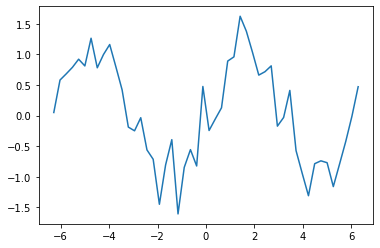

In [ ]:
cuda = "cuda:0"
import numpy as np
import matplotlib.pyplot as plt

sin_x = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
sin_y = np.sin(sin_x)+np.random.normal(0, 0.3, len(sin_x))  # sin関数に乱数でノイズを加える
plt.plot(sin_x, sin_y)

ノイズ付きサイン曲線の一部を入力とし、次の値を予測するようにRNNを訓練する

### データの前処理
入力、正解データをRNNに適した形に整形する
- 時系列データから次の値を予測できるように、時系列データを入力とし、正解をその時系列データの次の値とする

`input_data = np.zeros((n_sample, n_time, 1))`は入力構造そのものである
- unfoldしたとき、段数がn_time
- 今回の入力はサイングラフのyの値一つのみ
- データを次々と入力するが、それがn_sample回
- 以上を表現すると、3次元配列で、`(n_sample, n_time, 1)`となる

同様に`correct_data = np.zeros((n_sample, 1))`は、最後の(最新の)段の出力に対する正解データを示す

次のforループで実際にデータを投入している
- pythonマジックがあり慣れないと？かもしれない
- `correct_data[i]`は要素一つなのに、`sin_y[i+n_time:i+n_time+1]`って要素2個じゃないの？とか他の言語を触っている人は考えてしまう、分かっていても考えてしまう
  - pythonフリークは、何がわからないのかさっぱりわからないであろう
- sin_y[0]はnumpyのfloatの値、sin_y[0:1]はnumpy arrayを返して0から1個分の配列なので、要素数が1となる
  - これを0から1までの配列と思うとハマる
  - 違いは、arrayかどうか
- このreshapeの使い方もこれまで通りで、独特であるがあるあるなので抑えておくこと
  - modelに食べさせるテンソルは3次元で、これがないと2次元となり、`y = model(x)`などでエラーになる
  - 動いているコードの**データの型**をよく見ておくこと

次に、TensorDatasetでデータセットを作成

最後にDataLoaderでミニバッチを構成



In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
n_time = 10  # 時系列の数
n_sample = len(sin_x)-n_time  # サンプル数、len(sin_x)が50であるため、40となる
input_data = np.zeros((n_sample, n_time, 1))  # 入力で空の配列を生成
correct_data = np.zeros((n_sample, 1))  # 正解
for i in range(n_sample):
  input_data[i] = sin_y[i:i+n_time].reshape(-1, 1)
  correct_data[i] = sin_y[i+n_time:i+n_time+1]  # 正解は入力よりも一つ後
#   ここは、correct_data[i] = [sin_y[i+n_time]] このように記述しても同じです
input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # DataLoaderの設定
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### モデルの構築

まずはマニュアルを読むこと
- これでわからなかったらソースコードを読む
- パラメータは以下の通り

| | |
|:--|:--|
|input_size|入力の特徴量数x|
|hidden_size|隠れ状態の特徴量h|
|num_layers(=1)|スタック数、RNNを複数重ね合わせる構造|
|nonlinearity(=tanh)|活性化関数(`relu`/`tanh`)'|
|bias(=True)|バイアス重み利用切替(ON=True)|
|batch_first(=False)|入出力テンソルを(`batch`,`seq`,`feature`)で提供|
|dropout(=False)|最終層以外にDropout層を導入|
|bidirectional(=False)|双方向RNNとする|

- 入力(input, $h_0$)は次の通り

| | |
|:--|:--|
|input|入力シーケンスの特徴を含むテンソル<br>省略するがパックしてより詳細な情報を入力できる|
|$h_0$|内部状態初期値で省略すると0|

- 出力(output, $h_n$)は次の通り

| | |
|:--|:--|
|output|最終層からの出力特徴量($h_t$)を$t$ごとに含むテンソル|
|$h_n$|隠れ状態のテンソル|

- 入力はパックでき、output.view(seq_len, batch, num_directions, hidden_size)であるが、パックされた場合も同様の次元をもつ
- 出力は$h_n$.view(num_layers, num_directions, batch, hidden_size)として分離できる

### さて、PyTorchの癖を学ぼうか

`nn.Module`を継承したクラスとしてモデルを構築する
- 特に面倒なところはPyTorchではnn.RNNとして準備されているので、これを利用するだけである
  - 中身の詳細がわからなくても、どういうもので、どういうときに使うかさえ知っていれば設計できる
  - PyTorchにはRNNとRNNCellという，ユニット全体とユニット単体を扱うクラスがあるので注意する
- `batch_first`をTrueにすると，`(seq_len, batch, input_size)`と指定されている入力テンソルの型を`(batch, seq_len, input_size)`にできる
  - 初期はDataLoaderと同じFalseの並びであったのが、互換性を維持して新規にbatch_firstを導入した

GPUを利用するため、入力のxはGPUへ、検証の際の正解データyもGPUに送る必要がある
- 学習の入力は全てGPUに送っておくこと、また余計なものはおくらないこと
- `RNN().to('cuda')`と、最低でも書いておけば、エラーでデータがCPUとGPU両方に存在すると伝えられるので、これを順番に片付けていけばよい

RNNの肝は、`y_rnn, hidden = self.rnn(x, None)`である
- 実はこれだけでよく、Noneと書くと、ゼロ初期化される
  - init_hiddenも実は不要
- Noneを具体的に書くと次の通り
```
torch.zeros(self.n_layers, batch_size, self.hidden_size)
```
- ここでは、さらに`init_hidden`と関数化している
  - もし、init_hiddenを関数化したならば、その戻り値はGPU内部に存在しないといけないので、`to(device)`が必要

### さて、pythonの癖を学ぼうか

およそ疑問に思うのは次の点であろう
- なぜ n_layersとhidden_sizeだけselfなのか？
  - まずselfを付けるということは、オブジェクト変数であることを理解する(クラス変数というのもある)
  - インスタンスされるたびにメモリに領域が獲得され、インスタンス毎に違う値をとることができる
  - 呼び出された`def __init__`内であれば、呼び出されたスコープ(この関数内)で使って捨てられてもよいのでselfは要らない
  - ところが、`n_layers`と`hidden_size`は`init_hidden`でも使われており、`init_hidden`を呼び出したときには既に`__init__`のスコープ外でアクセスできないのでselfを付ける必要がある
  - これも、忘れたところでエラーになるのでそれほど問題ではない(だったら、勝手に判断しろよと言いたい)

- では、y_rnn, hidden, inithはselfじゃなくてよいのか？
  - まずforward中だけで毎回メモリから確保されても特に困らない、こだわりのスピード狂ならば、selfにしてもよい

- `y_rnn[:, -1, :]`はなに？
  - まず、訓練時のy_rnnは、torch.Size([8, 10, 64])という型になる
  - テストのときは、torch.Size([1, 10, 64])という型になる
    - これはミニバッチなので当然
  - 次に、-1は最後のデータ、-2は最後から2つ目のデータの意味で、:は、全ての意味
  - もし、この`[:, -1, :]`そのものがわからないという場合は、過去の課題を再確認するとよい

### さて、RNNのハマり所を学ぼうか

込み入ったことをせず、一般的なRNNを記述する上では特に疑問はないと思うが、次の点は注意した方が良い

- `n_time`回繰り返して利用するはずなのに、その指定がどこにもないけど、大丈夫か？
  - おそらく、疑問に思う人はいるかもしれない
    - 「入力xのサイズをみて判別できるが、その前にトポロジが確定しているのでダメでしょう」というごもっともそうな意見
    - ここまでで何も疑問を持たない人は、そのまま疑問がないまま過ぎた方が幸せかも
    - このごもっともそうな意見を聞いて「そうじゃん」と思ったら不幸かも
  - 疑問に思った人は、よく考えて欲しい、「すべての層で同じ重み、バイアスを利用する」ということを
    - つまり、トポロジは確定でき、入力xに従って「計算上」使いまわすだけなのだ

- `RNN(1, 64, 1, 1)`ってなに？input_sizeはn_timeが10だから`RNN(10, 64, 1, 1)`じゃないの？
  - 注意してマニュアルを見ると、Inputsは入力シーケンスの特徴を含むテンソルとあり配列ではない
  - バッチサイズを各回で変更できるため、そのための複数指定
  - 普通は1となることに注意する
    - この1個のテンソルに、バッチサイズ$\times$入力列$\times$次元が格納されている、つまり1個で十分な情報がある

例えば、これまで通りの記述でいけば、シンプルには、
```
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(1, 64, batch_first=True)
        self.fc = nn.Linear(64, 1)  # 全結合層
    def forward(self, x):
        batch_size = x.size(0)
        x = x.to(device)
        y_rnn, hidden = self.rnn(x, None) # ここを工夫すればinit_hiddenは不要
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y
model = RNN().to(device)
```
でよいが、次のような記述スタイルになると、**本当に理解しているか**が確認できるであろう

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers):
    super(RNN, self).__init__()
    self.n_layers = n_layers
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)  # 全結合層
  def forward(self, x):
    batch_size = x.size(0)
    x = x.to(device)
    inith = self.init_hidden(batch_size) 
    y_rnn, hidden = self.rnn(x, inith) # ここを工夫すればinit_hiddenは不要
    y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
    return y
  def init_hidden(self, batch_size):
    return torch.zeros(self.n_layers, batch_size, self.hidden_size).to(device)
model = RNN(1, 64, 1, 1).to(device)
print(model)

RNN(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


### 学習
モデルを訓練する

DataLoaderよりミニバッチを取り出しつつ訓練と評価を行う

ここでは、途中の訓練状況を見ることで、テーラー展開のように**徐々に(というか突然気が付いたように)サイン関数曲線に近づく**ところも観察する

Epoch: 0 Loss_Train: 0.7269433617591858


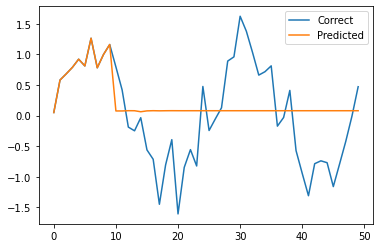

Epoch: 10 Loss_Train: 0.32642797827720643


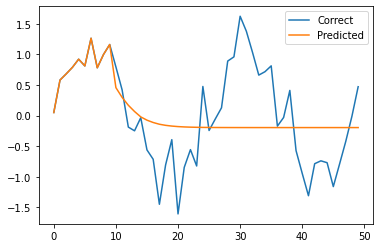

Epoch: 20 Loss_Train: 0.2557269737124443


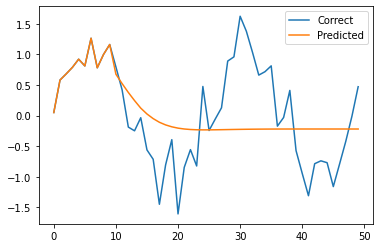

Epoch: 30 Loss_Train: 0.20962230265140533


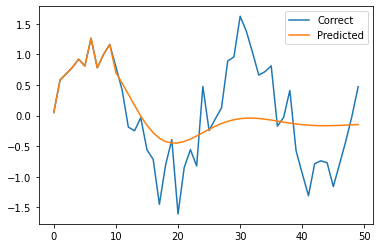

Epoch: 40 Loss_Train: 0.1750916376709938


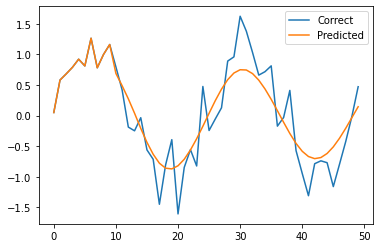

Epoch: 50 Loss_Train: 0.16765573769807815


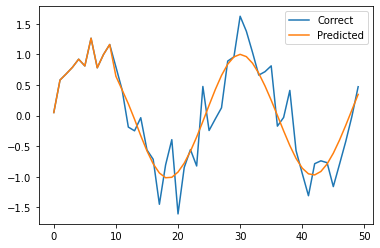

Epoch: 60 Loss_Train: 0.1629203051328659


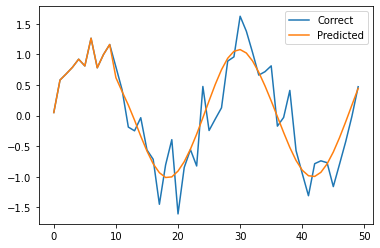

Epoch: 70 Loss_Train: 0.15557087808847428


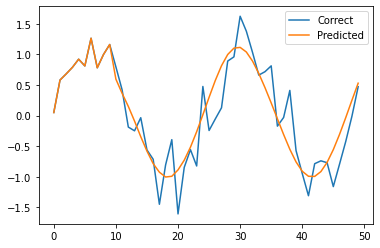

Epoch: 80 Loss_Train: 0.15173281878232955


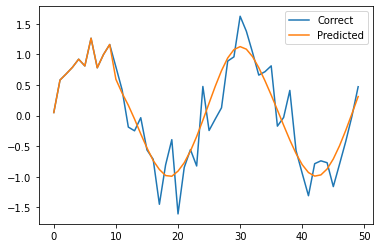

Epoch: 90 Loss_Train: 0.1514778181910515


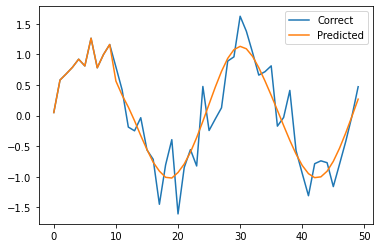

Epoch: 100 Loss_Train: 0.14872275292873383


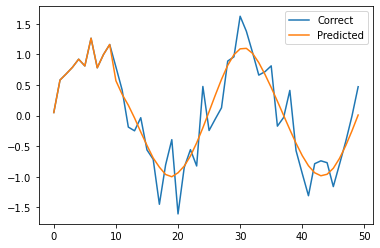

Epoch: 110 Loss_Train: 0.14955367743968964


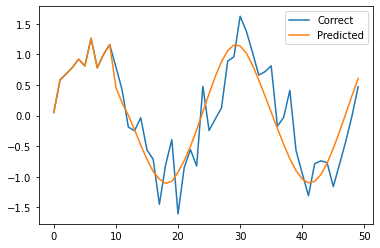

Epoch: 120 Loss_Train: 0.14156131446361542


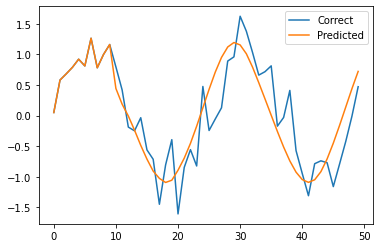

Epoch: 130 Loss_Train: 0.14075509309768677


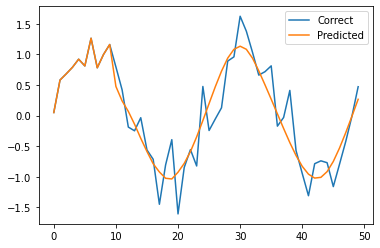

Epoch: 140 Loss_Train: 0.14238207042217255


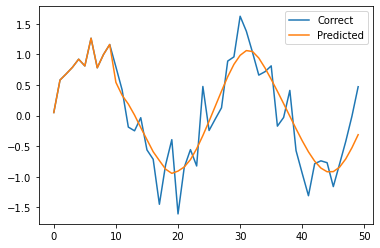

Epoch: 150 Loss_Train: 0.14425526857376098


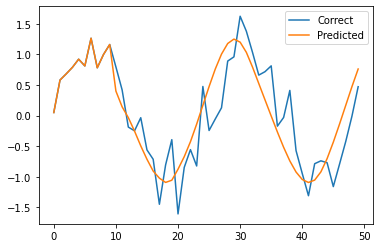

Epoch: 160 Loss_Train: 0.13555806428194045


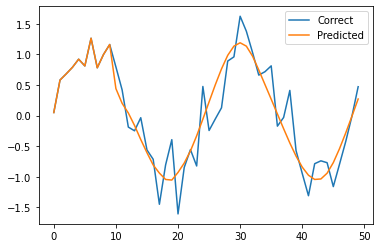

Epoch: 170 Loss_Train: 0.1405631348490715


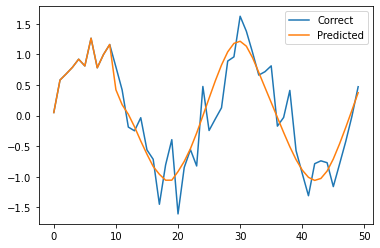

Epoch: 180 Loss_Train: 0.13092134147882462


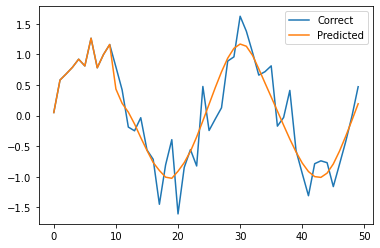

Epoch: 190 Loss_Train: 0.13251984789967536


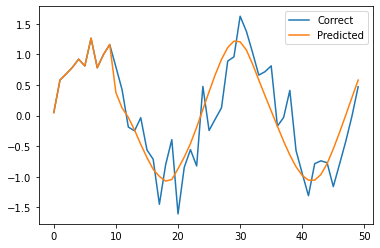

Epoch: 200 Loss_Train: 0.13455806523561478


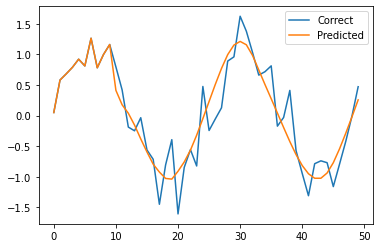

In [ ]:
# MSE誤差関数
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 学習率は0.01
# 損失のログ
record_loss_train = []
# 学習
for i in range(201):  # 200が見たいので、201エポック学習
  model.train()  # 訓練モード
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
    y = model(x)
    loss = loss_fnc(y, t.to(device))
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)
  if i%10 == 0:
    print("Epoch:", i, "Loss_Train:", loss_train)
    predicted = list(input_data[0].reshape(-1)) # 最初の入力
    model.eval()
    with torch.no_grad():
      for i in range(n_sample):
        x = torch.tensor(predicted[-n_time:])  # 直近の時系列を取り出す
        x = x.reshape(1, n_time, 1)  # (バッチサイズ, 時系列の数, 入力の数)
        y = model(x)
        predicted.append(y[0].item())  # 予測結果をpredictedに追加する
    plt.plot(range(len(sin_y)), sin_y, label="Correct")
    plt.plot(range(len(predicted)), predicted, label="Predicted")
    plt.legend()
    plt.show()        

### 誤差の推移

訓練データ、テストデータで誤差の推移をグラフに表示する  

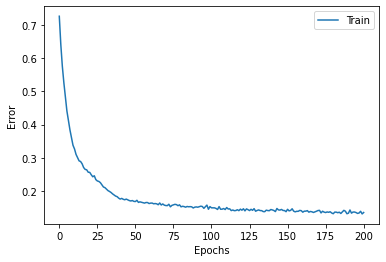

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

RNNでは、このような変曲点が現れるグラフになることが少なくない
- サイングラフならば、その全体の形がいきわたることが何回か体験する必要があり、シンプルなサインなので、一度かみ合えば急激に減衰する
- エポックを増やして、過学習にしてみるなど、実験してみよう

# LSTM

## LSTMの構造

LSTM(Long short-term memory:長・短期記憶)はRNNの拡張として1995年に登場した時系列データ(sequential data)に対するモデルである

RNNは再帰構造（先ほどWに全結合)を用いるが、LSTMは専用のLSTM層を用いることで、様々なRNNにおける問題に対応する

- Backpropagation Through Time(BPTT)による長いステップ、遠い過去の学習が困難であった
  - RNNのWに全過去の履歴を画一的に学習させるのは困難
  - 通常のRNNでも数十ステップの短期依存(short-term dependencies)には対応できるが、1000ステップといった長系列に依存する場合は学習できなかった

- RNNでは勾配消失問題に加えて勾配爆発問題も深刻であった
  - 大きくても小さくても問題となり、tanhを使って和らげているとはいえ、ステップ数が大きいと問題が発生しやすかった
  - LSTMでは過去のデータをsigmoidやtanhではなく「線形和」で保持するため問題が発生しにくい

LSTMも様々拡張されており、いくつかの有用なバージョンが存在する
- PyTorchでは、比較的新しい構造が実装されており、この構造について概説する

## LSTMの構造と特徴

以下の特徴的な構造をもつ
- **記憶セル**の導入による長期の記憶保持
- **ゲート**と呼ぶ情報の流れを調整する機構の導入
  - ゲートが記憶セルの内容を**忘れるか忘れないか**を判断し、必要な情報のみ次の段に引き継ぐ

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstmfig.png" width=400>

図において、$\oplus$は要素同士の和、$\otimes$は要素同士の積、$\sigma$はシグモイド関数を表す

全体の構造として、記憶セルから忘却ゲートとの積、入力ゲートとの和を経由して記憶セルに戻るパスがまず目につく

- このパスに対して忘却ゲートは積を算出するため、継承重みを制御される

- このパスに対する入力、つまり新しい情報の追加も入力ゲートにより制御される

- 記憶セルの内容が出力に影響する割合も出力ゲートにより制御される

これらのような要素により構成されている

LSTMは強力なモデルで、こうみると色々できそうに感じると思うが、実際はやみくもに設計、動作させても意味のある出力を得ることは極めて困難であり、緻密な問題設定が必要となる

LSTMの欠点は、その構造自体からどのような問題が解けるのか・なぜ解けない問題があるのかの判断が難しいことである
- 問題を選ぶ手法といえなくもない
- このやってみるしかない、という結論は工学的・科学的ではないと判断されやすく、機械学習研究を攻撃する格好の標的になっている



## LSTMによる画像生成

画像を時系列データと捉えてLSTMにより画像を生成させる

- torchvision.datasetsにあるFashion-MNISTの画像データを用いて訓練し、画像の上半分をもとに画像の下半分を予測、生成させる

- Fashion-MNISTは6万枚のファッションアイテム画像にラベルをつけたたデータセットである

  - 今回、ラベルは利用しない
  - 白黒であるため、生成しやすい

画像の学習と生成のイメージは次の図を参照するとよい
- 画像は次のように構成され、行ごと入力される

<img src="http://class.west.sd.keio.ac.jp/dataai/text/rnnimg1.png" width=200>

訓練においては、上半分つまり14行(t=0からt=13)を利用して15行目(t=14)を教師として学習する
- 次の行は図で言う(t=1からt=14)を利用して16行目(t=15)を教師として学習する

推定も同様である

<img src="http://class.west.sd.keio.ac.jp/dataai/text/rnnimg2.png" width=400>

なお、次のような疑問はごもっともである
- 入力14行だけを入力として、それぞれ別個に下の14行を学習させる、つまり14個の独立したモデルを持てばよいのではないか？
- そのとおりであるが、唯一のモデルで時系列もしくは、シリーズデータとして扱える点がRNNのメリットである

まず、Fashion-MNISTをロードし、25枚の画像をランダムに選び出す


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting mydata/FashionMNIST/raw/train-images-idx3-ubyte.gz to mydata/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting mydata/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mydata/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting mydata/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mydata/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting mydata/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mydata/FashionMNIST/raw

データ数: 60000


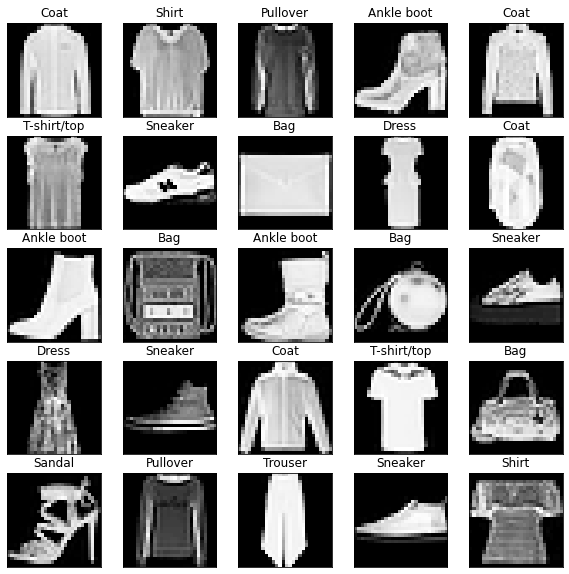

In [ ]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
fmnist_data = FashionMNIST(root="mydata",
                            train=True,download=True,
                            transform=transforms.ToTensor())
fmnist_classes = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
print("データ数:", len(fmnist_data))
n_image = 200  # バッチサイズ
fmnist_loader = DataLoader(fmnist_data, batch_size=n_image, shuffle=True)
dataiter = iter(fmnist_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す
img_size = 28 # FasionMNISTの画像サイズは28x28である
plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].reshape(img_size, img_size), cmap="Greys_r")
    label = fmnist_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

### データの前処理

画像データをPyTorchでの処理に適した形に整形する

- 画像の各行を時刻とみて時系列データに変換し、正解データは時系列における次の行とする

`train_imgs = train_imgs.reshape(-1, img_size, img_size)`について

- もともとは、`torch.Size([60000, 1, 28, 28])`というサイズであるが、これを`torch.Size([60000, 28, 28])`に変換している
- PyTorchではこのような処理はしばしば現れるため専用の`torch.squeeze`が用意されている
  - 例えば`train_imgs = train_imgs.squeeze()`としても同じ結果が得られる


In [ ]:
import torch
from torch.utils.data import DataLoader
n_time = 14  # 時系列の数
n_in = img_size  # 入力層のニューロン数
n_mid = 400  # 中間層のニューロン数 精度がそれほど必要なければ256でもよい。
n_out = img_size  # 出力層のニューロン数
n_sample_in_img = img_size-n_time  # 1枚の画像中のサンプル数
dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader)  # イテレータ
train_imgsr, labels = dataiter.next()  # データを取り出す
train_imgs = train_imgsr.reshape(-1, img_size, img_size) # サイズを整える
n_sample = len(train_imgs) * n_sample_in_img  # サンプル数
input_data = np.zeros((n_sample, n_time, n_in))  # 入力
correct_data = np.zeros((n_sample, n_out))  # 正解
for i in range(len(train_imgs)):
  for j in range(n_sample_in_img):
    sample_id = i*n_sample_in_img + j
    input_data[sample_id] = train_imgs[i, j:j+n_time]
    correct_data[sample_id] = train_imgs[i, j+n_time]
input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)  # DataLoaderの設定
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### テスト用のデータの作成

再びDataLoaderを用い、今度はtrain=Falseにして作る
- 今度はsqueezeを使ってみる

In [ ]:
n_disp = 10  # 生成し表示する画像の数
disp_data = FashionMNIST(root="mydata",
                        train=False,download=True,
                        transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader)  # イテレータ
disp_imgsr, labels = dataiter.next()  # データを取り出す
disp_imgs = disp_imgsr.squeeze().float()

### 画像生成用関数の定義

オリジナルの画像`disp_imgs`と、この画像の上半分をもとに下半分を生成した`gen_imgs`を並べて表示する
- はじめに画像の上半分を履歴として次の行を生成し、さらにその行を含んで新たな履歴として次の行を生成する、という処理を繰り返す

In [ ]:
genimgflag = 0
def generate_images():
  # オリジナル画像の表示(最初の1回のみ)
  global genimgflag
  if genimgflag == 0:
    print("Original:")
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
      ax = plt.subplot(1, n_disp, i+1)
      plt.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
      ax.get_xaxis().set_visible(False)  # 軸を非表示に
      ax.get_yaxis().set_visible(False)
    plt.show()
    genimgflag = 1
  # 下半分を生成した画像の表示
  print("Generated:")
  model.eval()
  with torch.no_grad():
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
      for j in range(n_sample_in_img):
        x = gen_imgs[i, j:j+n_time].reshape(1, n_time, img_size)
        x = x.to(device)  # GPU対応
        gen_imgs[i, j+n_time] = model(x)[0]
      ax = plt.subplot(1, n_disp, i+1)
      plt.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
      ax.get_xaxis().set_visible(False)  # 軸を非表示に
      ax.get_yaxis().set_visible(False)
    plt.show()

### モデルの構築
`nn.Module`モジュールを継承してクラスを構成

- LSTMは`nn.LSTM`を利用する
- 中身は RNNと変わらないので目新しさは特にない
- 今回はレイヤ数、つまりLSTMのスタック数は1とするため、指定は省略している

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class LSTMN(nn.Module):
  def __init__(self, input_size, hidden_size, n_output):
    super(LSTMN, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, n_output)  # 全結合層
  def forward(self, x):
    y_lstm, (h, c) = self.lstm(x, None)  # hは次の時刻に渡される値、 cは記憶セル
    y = self.fc(y_lstm[:, -1, :])  # yは最後の時刻の出力, 実際にはhも同じ
    return y
model = LSTMN(n_in, n_mid, n_out).to(device)
print(model)

LSTMN(
  (lstm): LSTM(28, 400, batch_first=True)
  (fc): Linear(in_features=400, out_features=28, bias=True)
)


LSTNの隠れ層のネットワークは先ほどの図(再掲する)であるが、`y, (h, c) = LSNM(x, None)`と記述すると、記憶セルがc、$x_i$の入力がx、$y$全体がy、$y$の最後がhである。つまり、`h=y[:, -1, :]`となる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstmfig.png" width=400>

これらのどの戻り値を使うべきかは、LSTMで解きたいタスクによる

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstmio.png" width=600>

その前の絵の情報(many)から次の行(one)を得たいので、 many to one モデルとなる
- 従って、LSTMの最後の隠れ層の出力hを使う
- hか、yの最後を使う

### 学習

モデルを訓練する

- **学習には40分程度必要となるので注意すること**

- `loss_fnc = nn.MSELoss()`は、各要素間の平均二乗誤差(L2ノルムの2乗)を算出する

- DataLoaderを用いてミニバッチを取り出して訓練と評価を行う

- 学習中はエポックごとに画像生成用関数generage_imagesにより生成画像が表示される

Epoch: 0 Loss_Train: 0.0169789627525469
Original:


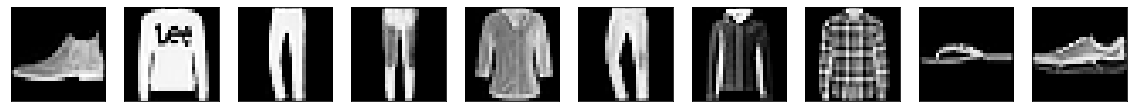

Generated:


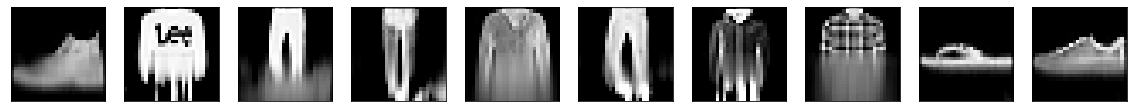

Epoch: 1 Loss_Train: 0.013187105873573822
Generated:


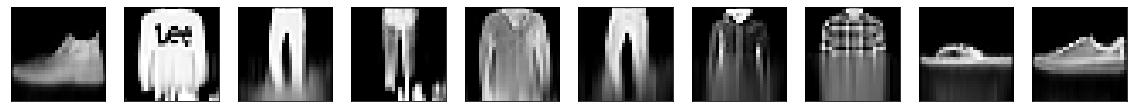

Epoch: 2 Loss_Train: 0.012110227057246261
Generated:


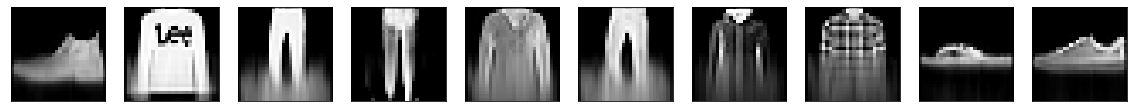

Epoch: 3 Loss_Train: 0.011493049719917662
Generated:


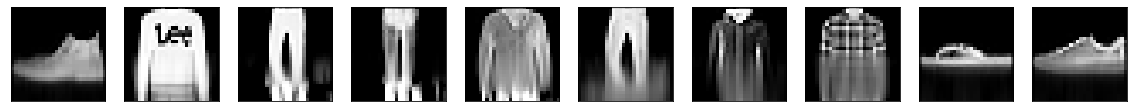

Epoch: 4 Loss_Train: 0.01105571865584771
Generated:


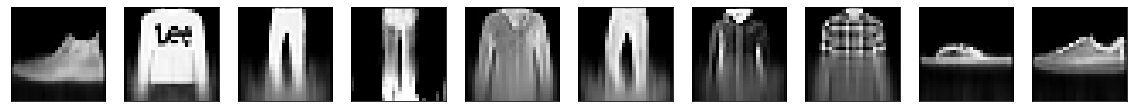

Epoch: 5 Loss_Train: 0.010701776386378979
Generated:


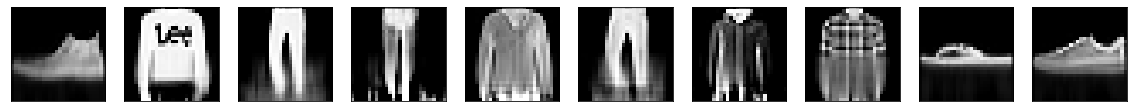

Epoch: 6 Loss_Train: 0.010391431333377683
Generated:


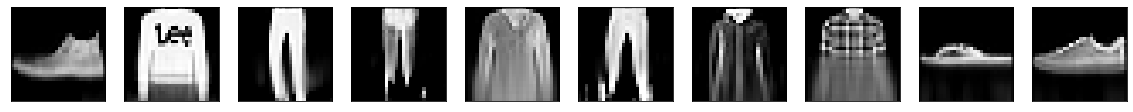

Epoch: 7 Loss_Train: 0.010124850911903531
Generated:


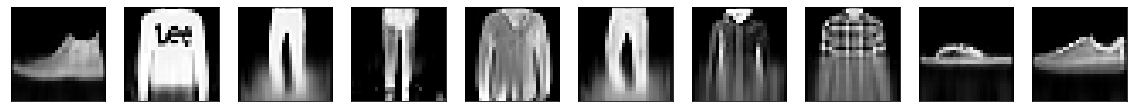

Epoch: 8 Loss_Train: 0.009883525018523071
Generated:


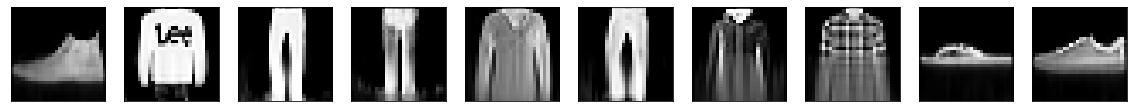

Epoch: 9 Loss_Train: 0.009669976803835561
Generated:


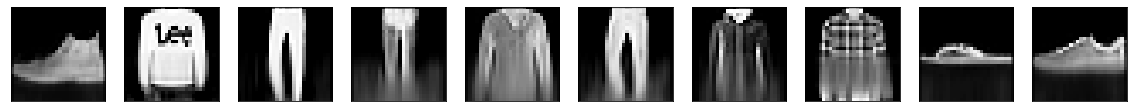

Epoch: 10 Loss_Train: 0.009480320679160941
Generated:


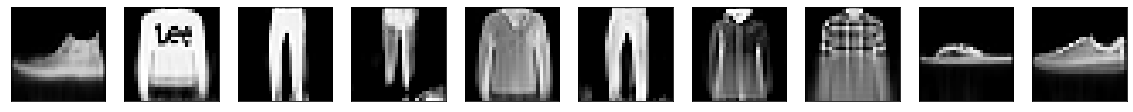

Epoch: 11 Loss_Train: 0.009295281867050946
Generated:


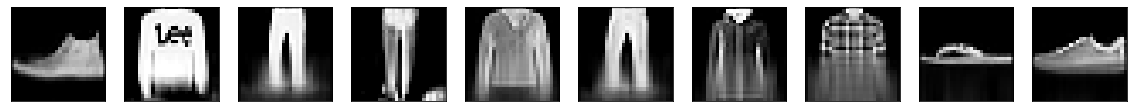

Epoch: 12 Loss_Train: 0.00913266376526233
Generated:


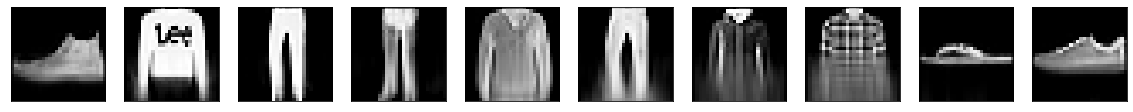

Epoch: 13 Loss_Train: 0.008991823739790955
Generated:


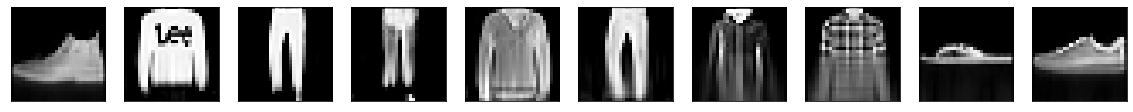

Epoch: 14 Loss_Train: 0.008844069211184524
Generated:


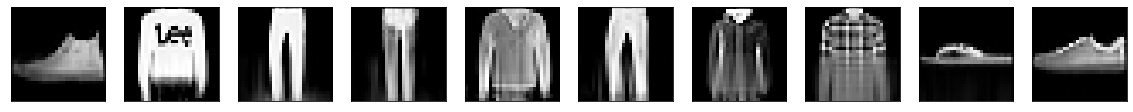

Epoch: 15 Loss_Train: 0.008723364522532775
Generated:


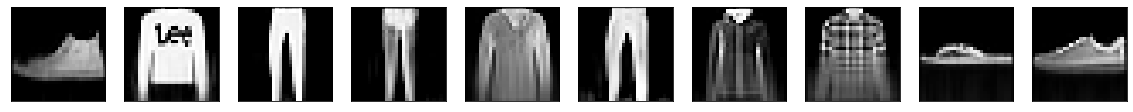

Epoch: 16 Loss_Train: 0.008594942819747155
Generated:


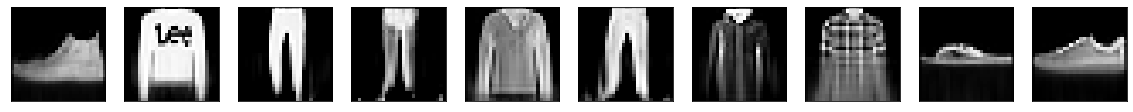

Epoch: 17 Loss_Train: 0.00848801610314472
Generated:


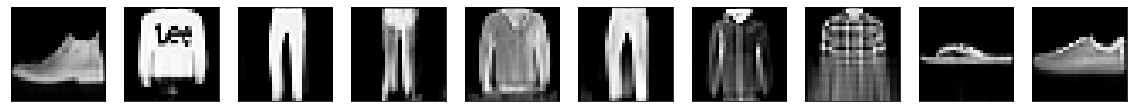

Epoch: 18 Loss_Train: 0.008377085438228913
Generated:


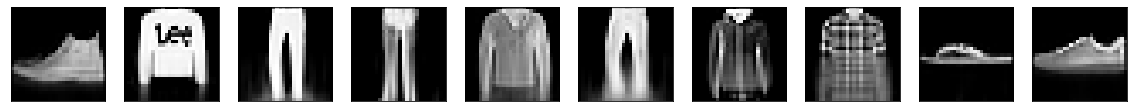

Epoch: 19 Loss_Train: 0.008278391906361827
Generated:


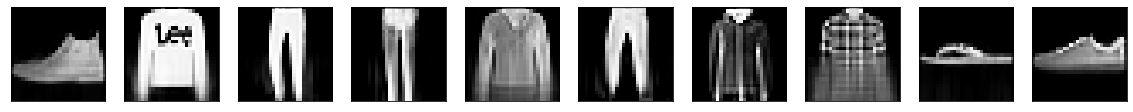

Epoch: 20 Loss_Train: 0.008187976389151034
Generated:


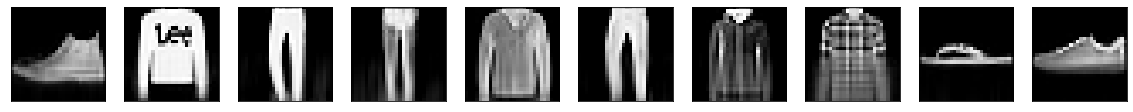

Epoch: 21 Loss_Train: 0.008092578428918185
Generated:


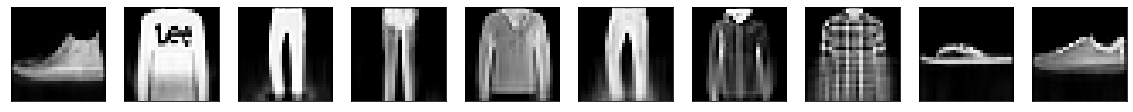

Epoch: 22 Loss_Train: 0.008011317394208944
Generated:


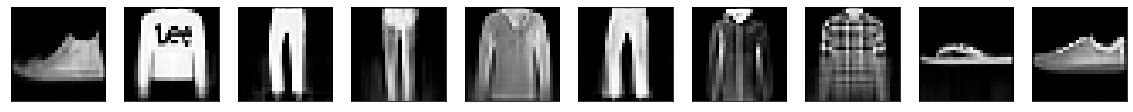

Epoch: 23 Loss_Train: 0.007937805053501137
Generated:


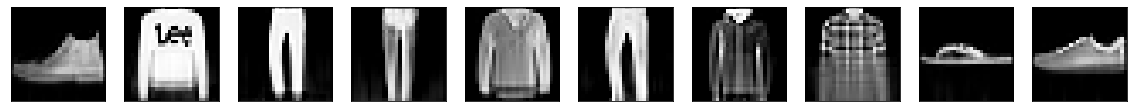

Epoch: 24 Loss_Train: 0.007862403241211655
Generated:


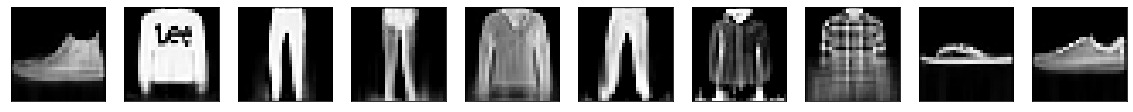

Epoch: 25 Loss_Train: 0.007794906364382903
Generated:


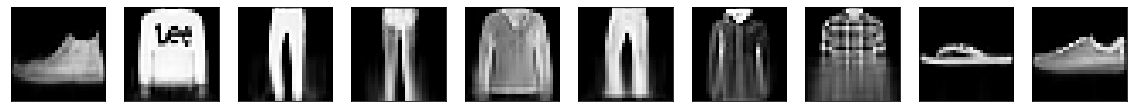

Epoch: 26 Loss_Train: 0.007719583116808366
Generated:


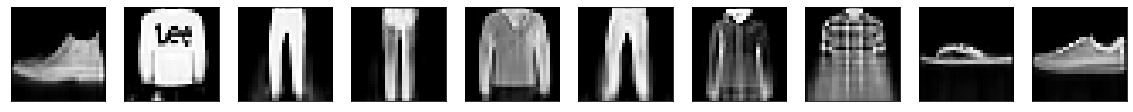

Epoch: 27 Loss_Train: 0.0076723667010653585
Generated:


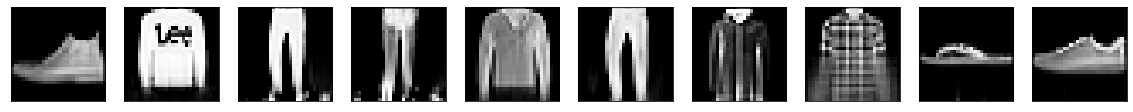

Epoch: 28 Loss_Train: 0.007596475438958562
Generated:


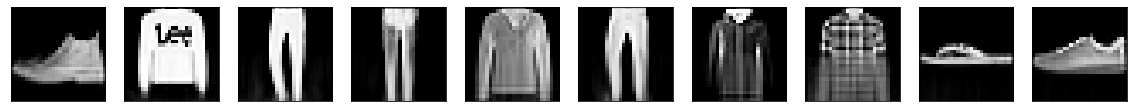

Epoch: 29 Loss_Train: 0.00755169575373524
Generated:


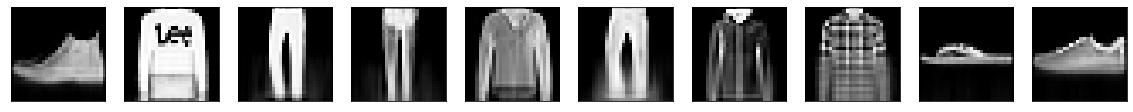

Epoch: 30 Loss_Train: 0.007488653437977618
Generated:


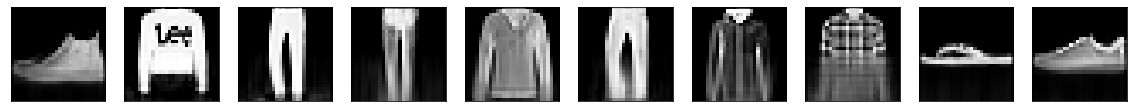

Epoch: 31 Loss_Train: 0.0074412427346942835
Generated:


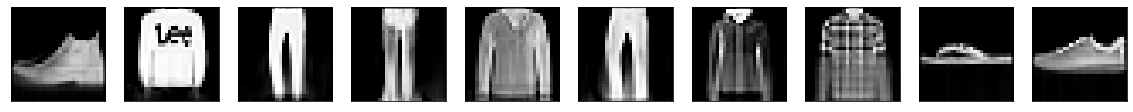

Epoch: 32 Loss_Train: 0.0073998573605971885
Generated:


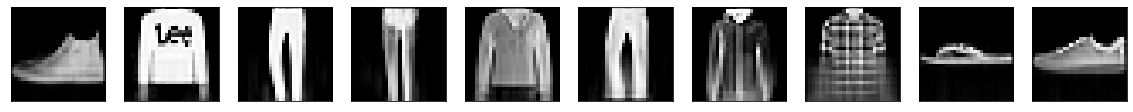

Epoch: 33 Loss_Train: 0.007343608441840815
Generated:


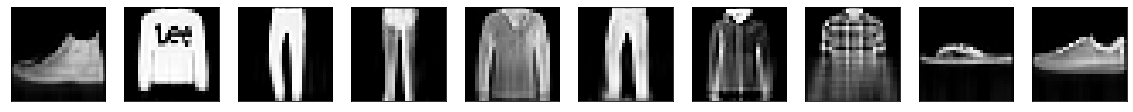

Epoch: 34 Loss_Train: 0.007295093113035996
Generated:


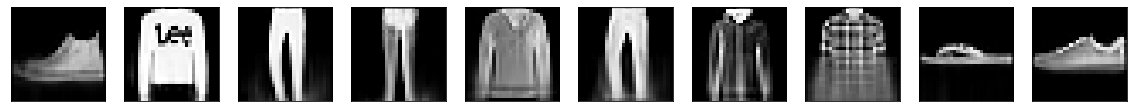

Epoch: 35 Loss_Train: 0.007250262473874633
Generated:


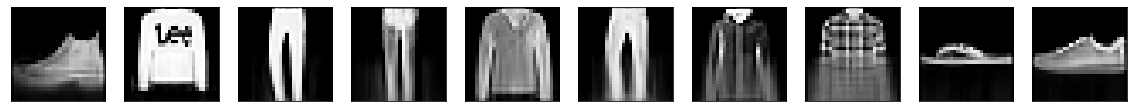

Epoch: 36 Loss_Train: 0.0072194690314186395
Generated:


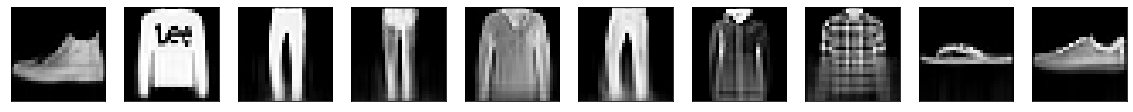

Epoch: 37 Loss_Train: 0.00717116414926777
Generated:


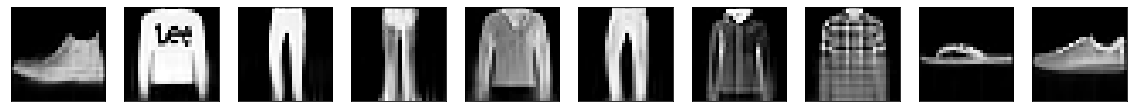

Epoch: 38 Loss_Train: 0.007146552614233372
Generated:


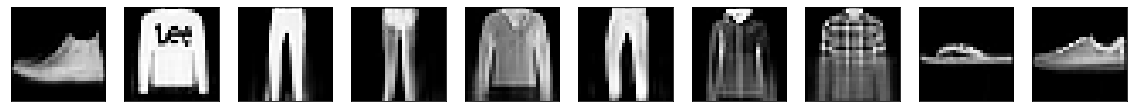

Epoch: 39 Loss_Train: 0.007105358902611316
Generated:


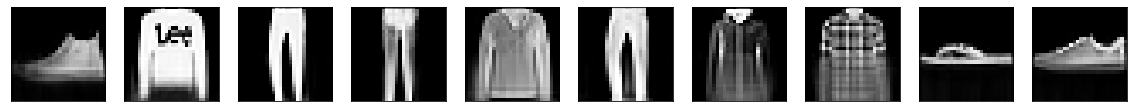

In [ ]:
from torch import optim
loss_fnc = nn.MSELoss()
# 最適化アルゴリズム
optimizer = optim.Adam(model.parameters())  # 学習率は0.01
# 損失のログ
record_loss_train = []
# 学習
for i in range(40):  # 40エポック学習 待ち遠しい場合は30エポックなどでも大丈夫
  model.train()  # 訓練モード
  loss_train = 0
  for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
    x, t = x.to(device), t.to(device)  # GPU対応
    y = model(x)
    loss = loss_fnc(y, t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)
  print("Epoch:", i, "Loss_Train:", loss_train)
  generate_images()

### 誤差の推移の確認

誤差の推移をグラフにより確認する

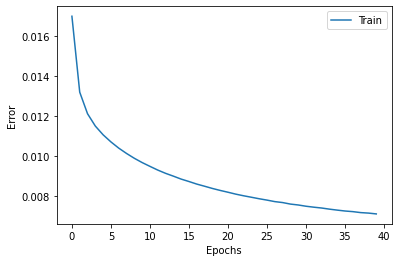

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

なお、ノード数が256の場合と400の場合では、次のような差がある
- 256ノードの時

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm256.png" width=200>

- 400ノードの時

<img src="http://class.west.sd.keio.ac.jp/dataai/text/lstm400.png" width=200>

y軸の差に注目、30エポックでは400ノードの方が精度がよく、さらに向上できる見込みがある(学習不足=underfittingともいえる状態)
- 1エポックあたりの所要時間は1割ほど増えている

# GRU

## GRUの構造

GRU(Gated Recurrent Unit: ゲート付き回帰型ユニット)は2014年に提案された機構であり、以下のような特徴をもつ

- LSTMに比してシンプルな構造で計算量が少ない
- 記憶セルと出力ゲートが存在しない
  - 内部状態数はGRUの方が出力ゲートがない分少ない
- 入力ゲートと忘却ゲート統合し更新ゲート(Update gate)を構成する
- 値をゼロにリセットするリセットゲート(Reset gate)が備わる

一部信号モデリングなどで性能がLSTMを上回ることがあるが、GRUが言語学習で失敗することがあるなど、LSTMはGRUよりも厳密に強力であることが示されている

<img src="http://class.west.sd.keio.ac.jp/dataai/text/gru.png" width=500>

図において、$\oplus$は要素同士の和、$(1-)$は1から引く演算、$\otimes$は要素同士の積、$\sigma$はシグモイド関数を表す

リセットゲート
- 新しい記憶を構成するためにどの程度過去の情報を利用するのかを決定するパラメタと考えることができる
- さらに、その調整には今の情報が利用される

更新ゲート

出力($Y=Y_t$)が新しい記憶($N$)と過去の情報($P=y_{t-1}$)で決定されているが、$Y=(1-\alpha)P+\alpha N$と読み取れる通り、出力を新しい記憶、過去の情報どちらに重きをおいて構成するかを与える






 ## GRUによる株価予測

先ほどはサインのグラフを扱ったが、実用性がよくわからないので、株価予測をGRUで行う
- Yahoo FinanceのWebページ情報をスクレイピングする、フリーで株価情報が取れる素晴らしいサイト

なお、次の点に注意しなければならない
 - 今回は日経平均株価を予測する
 - 銘柄ごとも取得できるが、Googleからのアクセスは流石にブロックされている様子なので、皆さんで工夫して、銘柄ごとの値を予測するようにしてみると良い
   - 日経平均株価情報もブロックされる可能性があるので注意すること
 - 実際に株価予測をして儲けるのであれば、きちんとお金を払ってAPIを用いて、ほぼリアルタイムな情報を入手し、APIで売買できるようにする必要があるであろう
 - 例えば野球やサッカーの点数を予測できるか？
   - 過去の点数履歴だけで予測するのはかなり困難であり、相手の情報や、野球なら、投手、打順、各選手の最近の成績、球場など、様々な情報を特徴量として取り込むべきであろう
   - そういう問題は別途ポアソン過程としてモデル化した方が興味深い結果が得られる
   - つまり、何をどのように解析したいかを知り、それに必要な情報をそろえるのは、AIではなく、人間であるということ
   - AIにとって都合の良い情報を上手くそろえていれば、あとはAIに任せばよい
   - その程度か？といわれるとその程度だが、データが大量にある場合は、AI利用のメリットが大きくなる

In [ ]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import urllib.request
import time

## 株価の取得
まずは株価サイトからデータを取ってくる
- ここでは、BeautifulSoupを用いる
  - WebスクレイパーであるBeautifulSoup自体は本筋からずれるため、別途学ぶためのシートを準備する
- スクレイピングすることで、webからデータを取得できる
  - より強力には、Selenimumや、Firefox marionetteを利用することになる
  - この授業の自動採点システム、閲覧状況自動取得システムは、Firefox marionetteが利用されている
  - オンラインチケット獲得には重要なツールとなりつつある
- Yahoo Financeで取得するデータの範囲は次の項目を指定しなおす
  - なお、これは仕様ではなく、解析結果であるのでいつ変更となってもおかしくはない
  - Googleからの取得もいつブロックされてもおかしくない
  - pを順番に増やしながら次々と画面を更新してデータを取得し、つなげていく

| | |
|:--|:--|
|sy|取得開始年|
|sm|取得開始月|
|sd|取得開始日|
|ey|取得終了年|
|em|取得終了月|
|ed|取得終了日|
|p|取得頁|



In [ ]:
def getstockfromweb():
  page_num = 20 # 取得するページ数
  tstock = []
  for i in range(page_num):
    # Yahoo Financeのページを利用 毎年フォーマットが変わるので調整が必要、うまくいかない場合はSlackか各自で修正すること
    # ここは2021/12/22版
    url = "http://info.finance.yahoo.co.jp/history/?code=998407.O&sy=2017&sm=1&sd=1&ey=2019&em=12&ed=31&tm=d&p=" + str(i+2)
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html, "lxml")
    estock = [value.get_text() for value in soup.find_all("td")[0:100]]
     #<td></td>に欲しい数値が文字で入っているのでその部分を抽出し、get_textで文字のみさらに抽出する
    tstock.extend(estock) # appendではなく一つの大きな配列にするためextendを使う
    time.sleep(0.1) # どんどんデータをとると、サーバが察知してデータが取れなくなる
  tstock = np.array(tstock) # NumPyへ変換
  stock = tstock.reshape(-1, 5)
  stock = pd.DataFrame(stock, columns=['date', 'open', 'max', 'min', 'close'], index=stock[:,0])
  stock = stock.drop('date',axis=1).apply(lambda x: x.str.replace(',','')).apply(lambda x: x.astype(np.float32))
  return stock
# この関数の実行を確認する場合は、次のコードセルを作成して実行するとよい
# stock = getstockfromweb()
# stock

次に、情報が取得できなかった場合、次の方法で各自取得して、次の関数を実行するとよい

取得方法は様々あるが、知られているのが株式投資メモ( https://kabuoji3.com/stock/ )であり、ここからならばスクレイピングでも銘柄別で取得できるが、Googleはブロックされている
- 各自銘柄コードと年度を入力して個別株価データを入手し、CSVデータをダウンロードする(数字4桁_年度.csv)というデータが取得できる
- これを、ファイル名をstockdata.csvに変更する
- 左のフォルダメニューを開き、stockdata.csvをドラッグしてファイルをコラボラトリに入れる
- 次の関数は、stockdata.csvを読んで解析する

In [ ]:
def getstockdata():
  path = 'stockdata.csv'
  with codecs.open(path, "r", "Shift-JIS", "ignore") as f:
    stock = pd.read_table(f, delimiter=",", header=None, names=['date', 'open', 'max', 'min', 'close', 'total', 'adjustment'])
    stock = stock.drop(stock.index[[0,1]])[['open', 'max', 'min', 'close', 'total', 'adjustment']].apply(lambda x: x.astype(np.float32))
  return stock

いつもの通りの前準備だが、新たに`torch.manual_seed`が呼び出されている
- これは、実験の再現性を高めるため、同じ乱数を生成させる
- 研究用途などで利用されるテクニック
  - False=0で同一系列の乱数を生成し、True=1で一般的な乱数となる


In [ ]:
import numpy as np
import pandas as pd
import codecs
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(1)

whichdataをTrueにするかFalseにするかで、webスクレイピングによる情報取得か、ダウンロードしたデータを利用するのかを切り替えることができる

どちらも共通して、dfというpandas DataFrame形式に保存される

In [ ]:
whichdata = False # webスクレイピングを利用する、Falseでダウンロードデータを利用する
if whichdata==True:
  dfp = getstockfromweb()
  print(dfp.dtypes)
  print(dfp)
  df = dfp.reset_index(drop=True).drop(columns=['open', 'max', 'min'])
else:
  import os
  if not os.path.exists('stockdata.csv'):
      #!wget "https://drive.google.com/uc?export=download&id=1OsqF2vQ94ZF8gA0IEjhp0rJM-2lnyfUw" -O stockdata.csv
      !wget https://keio.box.com/shared/static/xml20yn9im6xiytxe5z25wbja242g61k -O stockdata.csv
  dfp = getstockdata()
  print(dfp.dtypes)
  print(dfp)
  df = dfp.reset_index(drop=True).drop(columns=['open','max','min','total','adjustment'])
df

--2021-12-15 16:55:28--  https://keio.box.com/shared/static/xml20yn9im6xiytxe5z25wbja242g61k
Resolving keio.box.com (keio.box.com)... 185.235.236.197
Connecting to keio.box.com (keio.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/xml20yn9im6xiytxe5z25wbja242g61k [following]
--2021-12-15 16:55:28--  https://keio.box.com/public/static/xml20yn9im6xiytxe5z25wbja242g61k
Reusing existing connection to keio.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://keio.app.box.com/public/static/xml20yn9im6xiytxe5z25wbja242g61k [following]
--2021-12-15 16:55:29--  https://keio.app.box.com/public/static/xml20yn9im6xiytxe5z25wbja242g61k
Resolving keio.app.box.com (keio.app.box.com)... 185.235.236.201
Connecting to keio.app.box.com (keio.app.box.com)|185.235.236.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b1!i

,close
0,2690.0
1,2750.0
2,2711.0
3,2749.0
4,2755.0
...,...
148,2276.0
149,2255.0
150,2228.0
151,2271.0


学習用データを作成する
- pandasからnumpyに変換するにはvaluesを使う
- 直接金額を扱ってもよいが、株価予測の場合、銘柄間の変動予測や銘柄間の相関性も扱うことが多いことから、金額ではなく割合で評価した方が将来的に応用できやすいであろう
  - データ全体から最大値、最低値を取得し、その割合をもって学習させる
  - この方法では、突発的な価格上昇や下落には対応できない
  - 普通にmin, max標準化を行う
    - 正規分布で正規化すると、外れ値が大きな値となり、外れ値に引きずられた結果となる


In [ ]:
#訓練データとテストデータに分割
test_size = 0.3
sp = df['close'].values # pandasからnumpyへ変換
total_len = len(sp)
test_len = int(len(sp)*test_size)
train_len = total_len - test_len
print("total_len:", total_len, " train_len:", train_len, "test_len:", test_len)
train = sp[0:train_len]
test = sp[train_len:total_len]
x_max, x_min = max(sp), min(sp)
train_norm = (train - x_min) / (x_max - x_min)
test_norm = (test - x_min) / (x_max - x_min)

total_len: 153  train_len: 108 test_len: 45


テータを分割する
- DataLoaderに食べさせるデータを作る
- n_timesのブロックを入力とし、次のデータを教師とするデータを作成する
- 訓練用とテスト用の両方作成する

In [ ]:
#時系列データに分割
n_time = 6
x_train, y_train, x_test, y_test= [], [], [], []
for i in range(train_len-n_time):
  x_train.append(train_norm[i:i+n_time].reshape(-1,1))
  y_train.append(train_norm[i+n_time])
for i in range(test_len-n_time):
  x_test.append(test_norm[i:i+n_time])
  y_test.append(test_norm[i+n_time])

作成したデータをTensorDatasetとしてDataLoaderに渡す
- この時torchテンソルに変換する必要がある

In [ ]:
epochs = 50
batch_size = 32
input_data = torch.tensor(x_train, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(y_train, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成
train_loader = DataLoader(dataset, batch_size=batch_size)
device = torch.device(cuda if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  This is separate from the ipykernel package so we can avoid doing imports until


GRUを指定する

RNN, LSTM, GRUは、基本的に名前だけ変えればよいのがわかるであろう

In [ ]:
class GRUN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRUN, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x = x.to(device)
    y_gru, h = self.gru(x, None)
    y = self.fc(y_gru[:, -1, :])
    return y
model = GRUN(1, 100, 1).to(device)
print(model)

GRUN(
  (gru): GRU(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


損失関数に平均二乗誤差、最適化にはADAMを利用する
- これらも定番

In [ ]:
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
record_loss_train = []
for i in range(epochs):
  for j, (x, t) in enumerate(train_loader):
    x, t = x.to(device), t.reshape(-1,1).to(device)
    y = model(x)
    loss = loss_func(y, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss /= j+1
  record_loss_train.append(loss)
  print(f'epoch: {i:3} loss: {loss.item():10.8f}')

epoch:   0 loss: 0.00967935
epoch:   1 loss: 0.00280316
epoch:   2 loss: 0.00451574
epoch:   3 loss: 0.00312620
epoch:   4 loss: 0.00327820
epoch:   5 loss: 0.00317253
epoch:   6 loss: 0.00380983
epoch:   7 loss: 0.00188703
epoch:   8 loss: 0.00322448
epoch:   9 loss: 0.00181429
epoch:  10 loss: 0.00336590
epoch:  11 loss: 0.00148389
epoch:  12 loss: 0.00350043
epoch:  13 loss: 0.00116995
epoch:  14 loss: 0.00380801
epoch:  15 loss: 0.00111535
epoch:  16 loss: 0.00505427
epoch:  17 loss: 0.00144986
epoch:  18 loss: 0.00570021
epoch:  19 loss: 0.00111855
epoch:  20 loss: 0.00194131
epoch:  21 loss: 0.00167480
epoch:  22 loss: 0.00076093
epoch:  23 loss: 0.00187045
epoch:  24 loss: 0.00079759
epoch:  25 loss: 0.00085600
epoch:  26 loss: 0.00116590
epoch:  27 loss: 0.00068414
epoch:  28 loss: 0.00100963
epoch:  29 loss: 0.00079887
epoch:  30 loss: 0.00076069
epoch:  31 loss: 0.00088649
epoch:  32 loss: 0.00069236
epoch:  33 loss: 0.00079176
epoch:  34 loss: 0.00069998
epoch:  35 loss: 0.0

学習した結果を用いて、実際に推定を行う
- 本来は、違う年度で行うのが正しいであろうが、Fasion-MNISTも同様に、このあたりは授業で扱い方を学ぶという観点から、若干おおらかになっている

途中、`in_true = list(sp_norm.reshape(-1).astype(np.float32))`といった記述があるが、極めて重要な記述である
- CPUはFloat64つまり、64bit CPUを搭載したパソコン(64bit PCなどともいうが)が普通に流通しており、このCPUで表現できるデータとして保存している
- GPUはFloat32つまり、32bitで構成されている
  - これは、画像では32bitあれば、24bitフルカラー+$\alpha$が表現できるため十分である
  - 機械学習用途でも、ビット幅は学習精度にほとんど影響を与えず、Float32(FP32)の他、Float16(FP16)もよく利用されている
    - 中にはINT8, INT4, INT2といった特殊な表現も研究されている
  - 以上のように、変数の表現を簡略化して計算性能を挙げているという見方もできる

つまり、GPUではFloat32を使ってデータをつけつけ、また内部も表現されている
- このGPUにCPUが扱えるFloat64をそのまま入れるとエラーになる
  - 実際に`.astype(np.float32))`を削除して試してみると良い
  - なぞなRUNTIME ERRORとなり、原因究明すらも難しい状態にるかもしれないが、それでも型を調べて何が違うのかを追いかけると、簡単に誤りにたどり着くことができる
    - きちんとFloat32かFloat64かは区別できるようになっている

したがって、Float64をそのままGPUに入れるとエラーになる
- つまり、GPUを使う前提であれば、FP32にするのが得策である
- CPUは汎用性をうたっており、この点はどうでもよく、FP16、FP32、FP64すべて問題なく動作できる


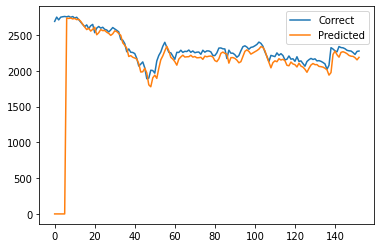

In [ ]:
sp_norm = sp/x_max
in_true = list(sp_norm.reshape(-1).astype(np.float32)) # ここの意味を理解する
pred = []
model.eval()
for i in range(n_time):
  pred.append(0)
with torch.no_grad():
    for i in range(len(sp)-n_time):
      x = torch.tensor(in_true[i:i+n_time])  # 直近の時系列を取り出す
      x = x.reshape(1, -1, 1)  # (バッチサイズ, 時系列の数, 入力の数)
      y = model(x)
      pred.append(y[0].item())  # 予測結果をpredictedに追加する
plt.plot(range(len(sp)), sp, label="Correct")
pred = np.array(pred)
pred = pred * x_max
plt.plot(range(len(pred)), pred, label="Predicted")
plt.legend()
plt.show()

なお、
- 翌日予測が値を下げるようであれば、今のうちに売る
- 翌日予測が値を上げるようであれば、今のうちに買う

という操作の他、
- その時の手数料も勘案して、利益が上がると確定できるときに売る
- 予測毎の確度を得て、その確度に応じて売る量を決める
- 経済的情勢などを特徴量に加える

などの追加ができるであろう

# 課題 (RNN)

上記株価予想を、さらにRNNおよびLSTMを用いて評価し、3つの結果を比較しなさい
- 結果は比較するだけでよいが、考察があるとなおよい
- 但し「定量的な評価」で比較すること